# Transfer Learning with TensorFlow Part2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning.

In [1]:
# Check if we're using a GPU
!nvidia-smi

Mon Aug 15 16:07:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious.

So, it's a good idea to put functions we'll want to use again in a script we can download and import into our notebooks (or elsewhere).

We can download some of the functions we've used previously from daniel bourke's github here: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

Or we could rewrite all of them again. In my opinion, rewriting them again is the best way to practice.

In [2]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

--2022-08-15 16:07:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-15 16:07:17 (109 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within tf.keras.applications and apply them to our own problem (recognizing images of food). 

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2022-08-15 16:07:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.215.128, 173.194.216.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   145MB/s    in 1.1s    

2022-08-15 16:07:23 (145 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Create training and test directory paths
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [7]:
import tensorflow as tf 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE, 
                                                                label_mode = 'categorical',
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out the class names of our data
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[1.37897949e+02 5.76989784e+01 4.25969391e+01]
   [1.39581635e+02 6.75357208e+01 5.00102043e+01]
   [1.54989792e+02 8.88469391e+01 7.09948959e+01]
   ...
   [3.36376991e+01 3.12805538e+01 2.03519840e+01]
   [3.36173935e+01 3.36173935e+01 2.36173954e+01]
   [3.88724709e+01 3.88724709e+01 2.93316307e+01]]

  [[1.39897949e+02 5.69030609e+01 3.92346954e+01]
   [1.29647964e+02 5.42857132e+01 3.51530609e+01]
   [1.41255112e+02 6.97397919e+01 5.02091866e+01]
   ...
   [3.74132233e+01 3.43417931e+01 2.76275082e+01]
   [3.50663376e+01 3.49949112e+01 2.72806244e+01]
   [3.59285698e+01 3.52602348e+01 2.93366699e+01]]

  [[1.43632660e+02 5.63469391e+01 3.71377563e+01]
   [1.36459183e+02 5.85867348e+01 3.57602043e+01]
   [1.36632660e+02 6.13520393e+01 3.86122437e+01]
   ...
   [3.84489937e+01 3.44489937e+01 3.30204201e+01]
   [3.65714302e+01 3.55714302e+01 3.31428566e+01]
   [3.57857132e+01 3.47857132e+01 3.23571434e+01]]

  ...

  [[1.74214294e+02 1.80000000e+02 1.76000000e+02]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [11]:
# 1. Create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top = False)

# 2. Freeze the base model(thus the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create input into our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input_layer')

# 4. If using a model like ResNet50V2 you will need to normalize inputs (we don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model and save its history
history_10_percent = model_0.fit(train_data_10_percent,
                              epochs = 5,
                              steps_per_epoch = len(train_data_10_percent),
                              validation_data = test_data,
                              validation_steps = int(0.25 * len(test_data)),
                              callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                       experiment_name = '10_percent_feature_extraction')])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220815-160742
Epoch 1/5
24/24 [==============================] - 23s 222ms/step - loss: 1.8787 - accuracy: 0.4293 - val_loss: 1.2947 - val_accuracy: 0.7023
Epoch 2/5
24/24 [==============================] - 4s 153ms/step - loss: 1.1409 - accuracy: 0.7213 - val_loss: 0.8902 - val_accuracy: 0.7993
Epoch 3/5
24/24 [==============================] - 4s 151ms/step - loss: 0.8409 - accuracy: 0.8160 - val_loss: 0.7345 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============================] - 4s 151ms/step - loss: 0.6892 - accuracy: 0.8387 - val_loss: 0.6279 - val_accuracy: 0.8339
Epoch 5/5
24/24 [==============================] - 4s 151ms/step - loss: 0.5865 - accuracy: 0.8587 - val_loss: 0.5751 - val_accuracy: 0.8487


In [12]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 6s 77ms/step - loss: 0.6106 - accuracy: 0.8352


[0.6105839610099792, 0.8352000117301941]

In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(f'Layer number: {layer_number}, Layer name: {layer.name}')

Layer number: 0, Layer name: input_1
Layer number: 1, Layer name: rescaling
Layer number: 2, Layer name: normalization
Layer number: 3, Layer name: stem_conv_pad
Layer number: 4, Layer name: stem_conv
Layer number: 5, Layer name: stem_bn
Layer number: 6, Layer name: stem_activation
Layer number: 7, Layer name: block1a_dwconv
Layer number: 8, Layer name: block1a_bn
Layer number: 9, Layer name: block1a_activation
Layer number: 10, Layer name: block1a_se_squeeze
Layer number: 11, Layer name: block1a_se_reshape
Layer number: 12, Layer name: block1a_se_reduce
Layer number: 13, Layer name: block1a_se_expand
Layer number: 14, Layer name: block1a_se_excite
Layer number: 15, Layer name: block1a_project_conv
Layer number: 16, Layer name: block1a_project_bn
Layer number: 17, Layer name: block2a_expand_conv
Layer number: 18, Layer name: block2a_expand_bn
Layer number: 19, Layer name: block2a_expand_activation
Layer number: 20, Layer name: block2a_dwconv_pad
Layer number: 21, Layer name: block2a_dw

In [14]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# How about we check summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


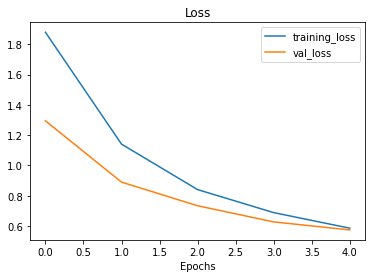

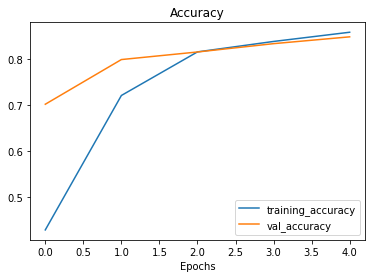

In [16]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)...

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2dD.

In [17]:
# Define the input shape 
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor:\n {input_tensor}')

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D global average pooled random tensor: \n {global_average_pooled_tensor}\n')

# Check the shape of the different tensors
print(f'Shape of input tensor: {input_tensor.shape}')
print(f'Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}')

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [18]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> 🔑**Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a feature **feature vector** a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer which can then be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the increadible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning wtih 1% of the training data with data augmentation.
2. `model-2` - use feature extraction transfer learning with 10% of the traning data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> 🔑**Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evalutaion metrics

### Getting and preprocessing data for model_1 

In [19]:
# Download and unzip the data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2022-08-15 16:08:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 74.125.28.128, 74.125.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   214MB/s    in 0.6s    

2022-08-15 16:08:37 (214 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [20]:
# Create training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [21]:
# How many images are we working with
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'

In [22]:
# Setup data loaders 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = 'categorical',
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than CPU.
* Image data augmentation only happens during training, thus we can still export our whole model and use it elsewhere.

In [23]:
# Import dependencies
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
    # preprocessing.Resclae(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in
], name = 'data_augmentation')

### Visualize our data augmentation layer (and see what happens to our data)

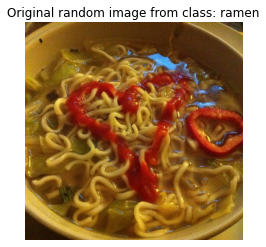

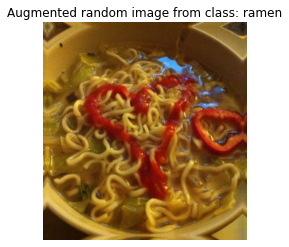

In [24]:
# View a random iamge and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random 
target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = random_image_path = target_dir + '/' + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0), training = True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img/255.))
plt.title(f'Augmented random image from class: {target_class}')
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [25]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape = input_shape, name = 'input_layer')

# Add in data augmentation Sequential Model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                         experiment_name = '1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220815-160842
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.4801 - accuracy: 0.0571 - val_loss: 2.2274 - val_accuracy: 0.1694
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1293 - accuracy: 0.2571 - val_loss: 2.1009 - val_accuracy: 0.2632
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9990 - accuracy: 0.4286 - val_loss: 1.9935 - val_accuracy: 0.3306
Epoch 4/5
3/3 [==============================] - 3s 1s/step - loss: 1.7774 - accuracy: 0.5714 - val_loss: 1.9192 - val_accuracy: 0.3832
Epoch 5/5
3/3 [==============================] - 3s 2s/step - loss: 1.6660 - accuracy: 0.5857 - val_loss: 1.8475 - val_accuracy: 0.4079


In [26]:
# Check out a model summary
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [27]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 1.8407 - accuracy: 0.4212


[1.8406951427459717, 0.4212000072002411]

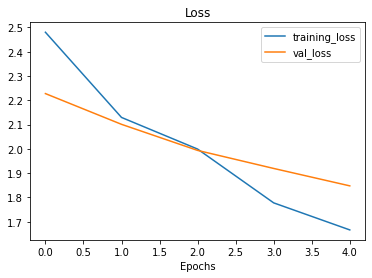

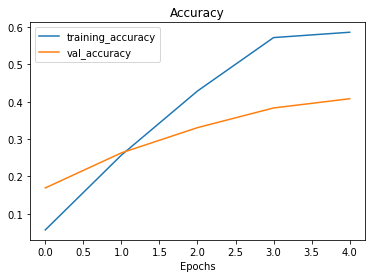

In [28]:
# How do the model with 1% of the data and data augmentation loss curves look?
plot_loss_curves(history_1_percent)

## Model 2: feature extraction transfer learning model with 10% of data and data augmentation

In [29]:
# Get 10% of data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the data
unzip_data('10_food_classes_10_percent.zip')

--2022-08-15 16:09:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.128, 173.194.213.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   158MB/s    in 1.0s    

2022-08-15 16:09:22 (158 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [30]:
# Setup the directories
train_dir_10_percent = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [31]:
# Set data inputs 
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = 'categorical',
                                                                            image_size = IMG_SIZE,
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [32]:
# How many images are in our directories?
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [33]:
# Create model 2 with data augmentation built-in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Built data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) # if using a model such as ResNet50V2, we'll need to rescale our data, efficientnet has rescaling built-in
], name = 'data_augmentation')

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create the inputs and outputs (including the layers between)
inputs = layers.Input(shape = input_shape, name = 'input_layer')
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training = False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name = 'global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])


In [34]:
# Check the summary of our model_2
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come back and start where we left off.

In [35]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                         save_weights_only = True, 
                                                         save_best_only = False,
                                                         save_freq = 'epoch', # save every epoch
                                                         verbose = 1)

### Fit model_2 passing in the ModelCheckpoint callback

In [36]:
# Fit the model saving checkpoints every epoch 
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs = initial_epochs,
                                          validation_data = test_data,
                                          validation_steps = int(0.25 * len(test_data)),
                                          callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                                   experiment_name = '10_percent_data_aug'),
                                                       checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220815-160926
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0100 - accuracy: 0.3280
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 19s 482ms/step - loss: 2.0100 - accuracy: 0.3280 - val_loss: 1.5185 - val_accuracy: 0.6201
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3729 - accuracy: 0.6853
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 447ms/step - loss: 1.3729 - accuracy: 0.6853 - val_loss: 1.0845 - val_accuracy: 0.7270
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0689 - accuracy: 0.7467
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 417ms/step - loss: 1.0689 - accuracy: 0.7467 - val_loss: 0.8423 - val_accuracy: 0.8010
E

In [37]:
# Check model_2 results on all test_data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 73ms/step - loss: 0.6972 - accuracy: 0.8112


[0.6972039341926575, 0.8112000226974487]

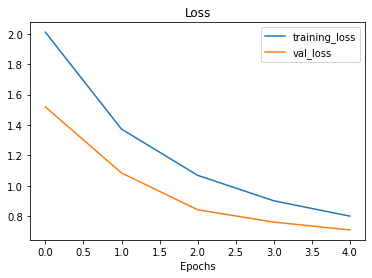

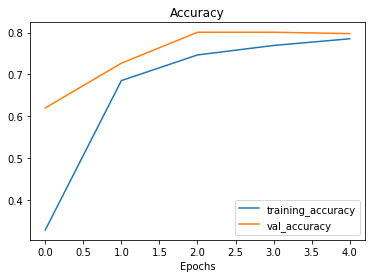

In [38]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint.

In [39]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [40]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6972 - accuracy: 0.8112


In [41]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked!
results_10_percent_data_aug == loaded_weights_model_results

True

In [42]:
# Let's check both of them
results_10_percent_data_aug, loaded_weights_model_results

([0.6972039341926575, 0.8112000226974487],
 [0.6972039341926575, 0.8112000226974487])

In [43]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [44]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[0. 0.]


## Model 3: Fine-tuning an existing model on 10% of the data

> 🔑**Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.



In [45]:
# Layers in loaded model
model_2.layers

In [46]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f5968b0b610> True
<keras.engine.sequential.Sequential object at 0x7f59688bb950> True
<keras.engine.functional.Functional object at 0x7f596859cd50> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f59688bbb10> True
<keras.layers.core.dense.Dense object at 0x7f5966defb90> True


In [47]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [48]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [49]:
# To begin fine-tuning, let's start by setting the last 10 layes of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10:
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), # when fine-tuning we typically want to lower the learning rate by 10x
                metrics = ['accuracy'])

> 🔑**Note:** When using fine-tuning it's best practice to lower our learning rate by some amount. How much? This is a hyperparameter we can tune. But a good rule of thumb is at least 10x (though different sources will claim other values). A good resource for information on this is ULMFiT paper: https://arxiv.org/abs/1801.06146

In [50]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [51]:
# Now we've unfrozen some of the layers closer to the top, how many trainable variables are there?
print(len(model_2.trainable_variables))

12


In [52]:
# Fine tune for another 5 epochs 
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps = int(0.25 * len(test_data)),
                                               initial_epoch = history_10_percent_data_aug.epoch[-1], # start training from previous last epoch,
                                               callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                                        experiment_name = '10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220815-161102
Epoch 5/10
24/24 [==============================] - 18s 442ms/step - loss: 0.6737 - accuracy: 0.8067 - val_loss: 0.5432 - val_accuracy: 0.8224
Epoch 6/10
24/24 [==============================] - 9s 380ms/step - loss: 0.5803 - accuracy: 0.8253 - val_loss: 0.5099 - val_accuracy: 0.8306
Epoch 7/10
24/24 [==============================] - 9s 365ms/step - loss: 0.4981 - accuracy: 0.8413 - val_loss: 0.5051 - val_accuracy: 0.8240
Epoch 8/10
24/24 [==============================] - 9s 370ms/step - loss: 0.4641 - accuracy: 0.8587 - val_loss: 0.4823 - val_accuracy: 0.8372
Epoch 9/10
24/24 [==============================] - 8s 313ms/step - loss: 0.4147 - accuracy: 0.8693 - val_loss: 0.5082 - val_accuracy: 0.8174
Epoch 10/10
24/24 [==============================] - 8s 323ms/step - loss: 0.3815 - accuracy: 0.8800 - val_loss: 0.5171 - val_accuracy: 0.8224


In [53]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 72ms/step - loss: 0.4943 - accuracy: 0.8328


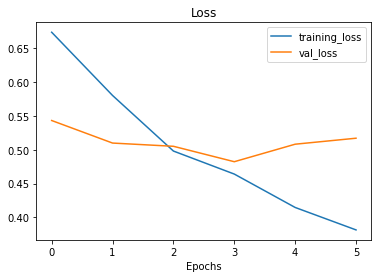

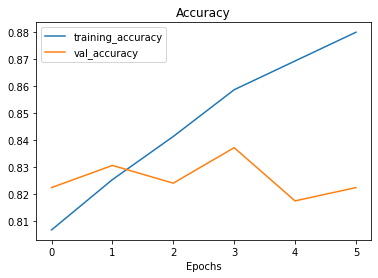

In [54]:
# Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [55]:
# Let's create a function to compare training histories
def compare_histories(original_history, new_history, initial_epochs = 5):
  """
  Compares two TensorFlow History objects.
  """
  # Get the original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original_history metrics with new_history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plot for accuracy
  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label = 'Training Accuracy')
  plt.plot(total_val_acc, label = 'Validation Accuracy')
  plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = 'Start Fine Tuning')
  plt.legend(loc = 'lower right')
  plt.title('Training and Validation Accuracy')

  # Make plot for loss
  plt.figure(figsize = (8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label = 'Training Loss')
  plt.plot(total_val_loss, label = 'Validation Loss')
  plt.plot([initial_epochs - 1, initial_epochs - 1], plt.ylim(), label = 'Start Fine Tuning')
  plt.legend(loc = 'upper right')
  plt.title('Training and Validation Loss');

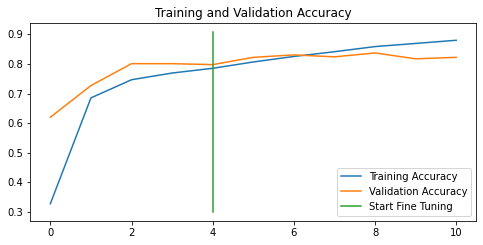

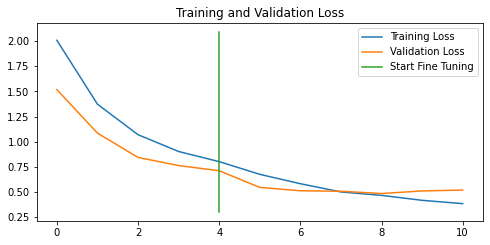

In [56]:
# Let's compare histories
compare_histories(history_10_percent_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs)

## Model 4: Fine-tuning and existing model on all of the data

In [57]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')

--2022-08-15 16:12:13--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.13.128, 172.217.193.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.13.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   178MB/s    in 2.8s    

2022-08-15 16:12:16 (178 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [58]:
# Setup training and test dir
train_dir_all_data = '10_food_classes_all_data/train'
test_dir = '10_food_classes_all_data/test'

In [59]:
# How many images are we working with now?
walk_through_dir('10_food_classes_all_data')

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 

In [60]:
# Setup data inputs 
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode = 'categorical',
                                                                                 image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset). Let's verify this... 

In [61]:
# Evaluate model_2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 7s 77ms/step - loss: 0.4943 - accuracy: 0.8328


[0.49431324005126953, 0.8327999711036682]

In [62]:
results_fine_tune_10_percent

[0.49431318044662476, 0.8327999711036682]

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights.

In [63]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [64]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.6972 - accuracy: 0.8112


[0.6972039341926575, 0.8112000226974487]

In [65]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6972039341926575, 0.8112000226974487]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (model_2) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time we're going to use all of the data (model_4).

In [66]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [67]:
# Let's drill into our base_model (efficientnetb0) and see what layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [68]:
# Compile 
model_2.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
                metrics = ['accuracy'])

In [69]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs = fine_tune_epochs,
                                           validation_data = test_data,
                                           validation_steps = int(0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                                    experiment_name = 'full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220815-161240
Epoch 5/10
235/235 [==============================] - 60s 231ms/step - loss: 0.7314 - accuracy: 0.7667 - val_loss: 0.4467 - val_accuracy: 0.8503
Epoch 6/10
235/235 [==============================] - 46s 192ms/step - loss: 0.5934 - accuracy: 0.8091 - val_loss: 0.4188 - val_accuracy: 0.8553
Epoch 7/10
235/235 [==============================] - 43s 179ms/step - loss: 0.5401 - accuracy: 0.8248 - val_loss: 0.3811 - val_accuracy: 0.8701
Epoch 8/10
235/235 [==============================] - 40s 169ms/step - loss: 0.4840 - accuracy: 0.8453 - val_loss: 0.3808 - val_accuracy: 0.8734
Epoch 9/10
235/235 [==============================] - 39s 164ms/step - loss: 0.4482 - accuracy: 0.8540 - val_loss: 0.3611 - val_accuracy: 0.8799
Epoch 10/10
235/235 [==============================] - 38s 161ms/step - loss: 0.4246 - accuracy: 0.8632 - val_loss: 0.3198 - val_accuracy: 0.8865


In [70]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)

79/79 [==============================] - 6s 73ms/step - loss: 0.3238 - accuracy: 0.8876


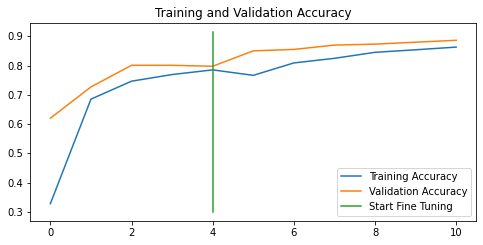

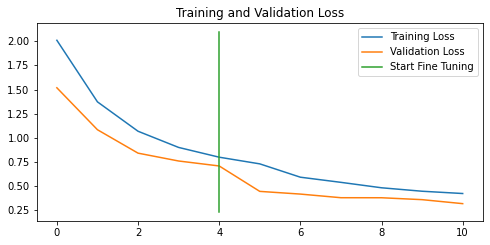

In [71]:
# How did fine-tuning go with more data?
compare_histories(original_history = history_10_percent_data_aug,
                  new_history = history_fine_10_classes_full,
                  initial_epochs = 5)

## Viewing our experiment data on TensorBoard

In [ ]:
# View tensorboard logs of transfer learning model experiments (should ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name 'Transfer Learning Experiments with 10 Food101 Classes' \
  --description 'A series of different transfer learning experiments with varying amounts of data and fine-tuning.' \
  --one_shot # exits the uploader once its finished uploading

My TensorBoard experiments are available at: https://tensorboard.dev/experiment/NAOGAx7mToaPPvWq6ZOnIw/